In [1]:
import numpy as np 
import pandas as pd 
import os

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, T5ForConditionalGeneration

import torch.nn as nn
from tensorflow.keras import activations, optimizers, losses


2024-05-19 02:41:47.016958: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-19 02:41:47.017068: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-19 02:41:47.276843: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 14.7 MB/s eta 0:00:00


In [3]:
from rapidfuzz.distance import Levenshtein

In [4]:
model_dir = "/kaggle/input/latex_t5/pytorch/num2word_plus_additional_trig_finetuning/1"
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)

In [6]:
!pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 1.1 MB/s eta 0:00:00


In [7]:
df = pd.read_excel('/kaggle/input/15k-for-inference-raw-tags/15k_test_set_WITH_DOLLAR_AUG.xlsx').sample(frac=1)

In [8]:
if torch.cuda.is_available():
    # Get GPU device name
    gpu_name = torch.cuda.get_device_name(0)
    print(f"GPU: {gpu_name}")
else:
    print(":( no gpu for u)")

GPU: Tesla T4


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MT5ForConditionalGeneration(
  (shared): Embedding(20100, 512)
  (encoder): MT5Stack(
    (embed_tokens): Embedding(20100, 512)
    (block): ModuleList(
      (0): MT5Block(
        (layer): ModuleList(
          (0): MT5LayerSelfAttention(
            (SelfAttention): MT5Attention(
              (q): Linear(in_features=512, out_features=384, bias=False)
              (k): Linear(in_features=512, out_features=384, bias=False)
              (v): Linear(in_features=512, out_features=384, bias=False)
              (o): Linear(in_features=384, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 6)
            )
            (layer_norm): MT5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): MT5LayerFF(
            (DenseReluDense): MT5DenseGatedActDense(
              (wi_0): Linear(in_features=512, out_features=1024, bias=False)
              (wi_1): Linear(in_features=512, out_features=1024, bias=False)
            

### Дальше -- сделать для основного инференса и пропустить для маленького 

In [10]:
import matplotlib.pyplot as plt 
from statistics import median, mean
from ast import literal_eval

для сетов без проблем с literal_eval

In [11]:
# находим уникальные теги
# def get_unique_tags(df):
#     uniques={}
#     for tags in zip(df['tags']):
#         # tags это тьюплы с одним элементом -- листом в виде строки
#         # т.ч. сначала эту строку достаём
#         # а потом literal_eval для того чтобы это было уже норм листом
#         #print(tags[0])
#         for tag in tags:
#             if tag in uniques:
#                 uniques[tag]+=1
#             else: uniques[tag]=1
#     return uniques

для там где надо literal_eval

In [12]:
# добавление запятых в искажённые теги
def insert_commas(tag_str):
    tag_list = tag_str[1:-1].split(' ')
    return '[' + ','.join(tag_list) + ']'

In [13]:
def get_unique_tags(df):
    uniques={}
    for tags in zip(df['tags']):
        # tags это тьюплы с одним элементом -- листом в виде строки
        # т.ч. сначала эту строку достаём
        # а потом literal_eval для того чтобы это было уже норм листом
        tags = insert_commas(tags[0])
        #print(tags)
       # print(literal_eval(tags[0]))
        for tag in literal_eval(tags):
            if tag in uniques:
                uniques[tag]+=1
            else: uniques[tag]=1
    return uniques

In [14]:
un=get_unique_tags(df)
len(un)

1059

In [15]:
# если хотя бы в 3% записей этот тэг есть
major_tags={key:value for key,value in un.items() if value>(len(df)*0.03)}

In [16]:
major_tags

{'complex-analysis': 471,
 'combinatorics': 551,
 'linear-algebra': 1097,
 'abstract-algebra': 732,
 'limits': 645,
 'probability': 769,
 'real-analysis': 1388,
 'calculus': 1693,
 'integration': 844,
 'matrices': 470,
 'algebra-precalculus': 742,
 'trigonometry': 451,
 'number-theory': 501,
 'sequences-and-series': 808,
 'elementary-number-theory': 602,
 'general-topology': 458}

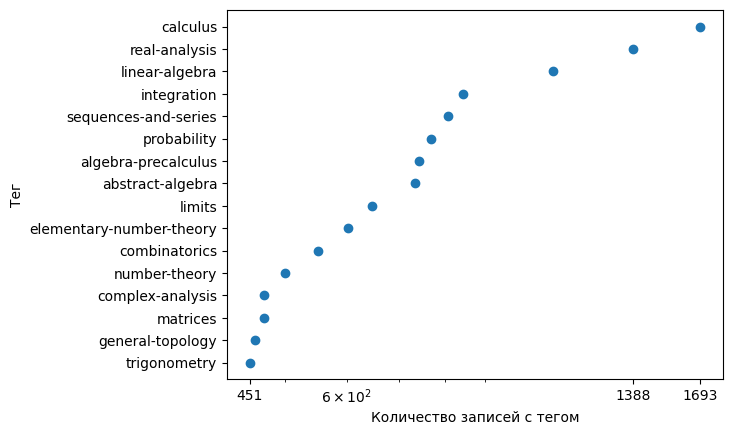

In [17]:
lists = sorted(major_tags.items(),key=lambda x:x[1]) 

y, x = zip(*lists)

fig, ax = plt.subplots()
ax.yaxis.set_tick_params(labelsize=10) 
plt.scatter(x, y)
plt.xlabel('Количество записей с тегом')
plt.ylabel('Тег')
plt.xscale('log')
ticks = [min(major_tags.values()),lists[-2][1], max(major_tags.values())] 
tick_labels = [f'{val}' for val in ticks]

plt.xticks(ticks, tick_labels)
plt.show()

In [18]:
df.head()

,Unnamed: 0,text_id,output_texts,input_texts,tags,augmentation,formulae_only
2776,7643,809475,"Проблемы этого типа, взятые из книг, часто уяз...","Проблемы этого типа, взятые из книг, часто уяз...",['complex-analysis' 'roots'],num2word,False
11148,2341,806979,"Чтобы две ладьи могли атаковать друг друга, он...","Чтобы две ладьи могли атаковать друг друга, он...",['combinatorics' 'problem-solving'],all_augments,False
4728,3345,903541,Пусть $B_W$ — базис для $W$. Расширьте его до ...,Пусть B_W — базис для W. Расширьте его до бази...,['linear-algebra' 'abstract-algebra'],rand_delet_and_typo,False
11692,315,109760,$$_x000D_\n\left(1-\left(1-\frac1n\right)^{f(n...,_x000D_\n\left 1-\left 1-\frac1n\right)^{f n...,['limits'],rand_delet_and_typo,True
5678,11423,113713,$$x=5\pm2\sqrt{6}$$,$$x=пять\pmвторой\sqrt{шесть}$$,['binomial-coefficients' 'binomial-theorem'],num2word,True


In [19]:
def reassign_tags(line, major_tags):
    #print(line)
    line = literal_eval(insert_commas(line))
    # если тегов нет
    if not len(line):
        return 'None'
    
    # смотрим есть ли у нас хотя бы один популярный тег
    populars = set(line).intersection(major_tags.keys())
    
    # если нет то тегаем как 'Разное'
    if not populars:
        return 'Other'
    # а если да - тегаем Самым популярным
    else:
        most_popular = max(populars, key=lambda tag: major_tags[tag])
        return most_popular


In [20]:
from tqdm import tqdm
tqdm.pandas()

In [21]:
df['tags'] = df['tags'].progress_apply(reassign_tags, args=[major_tags])

100%|██████████| 15000/15000 [00:00<00:00, 56651.92it/s]


In [22]:
df

,Unnamed: 0,text_id,output_texts,input_texts,tags,augmentation,formulae_only
2776,7643,809475,"Проблемы этого типа, взятые из книг, часто уяз...","Проблемы этого типа, взятые из книг, часто уяз...",complex-analysis,num2word,False
11148,2341,806979,"Чтобы две ладьи могли атаковать друг друга, он...","Чтобы две ладьи могли атаковать друг друга, он...",combinatorics,all_augments,False
4728,3345,903541,Пусть $B_W$ — базис для $W$. Расширьте его до ...,Пусть B_W — базис для W. Расширьте его до бази...,linear-algebra,rand_delet_and_typo,False
11692,315,109760,$$_x000D_\n\left(1-\left(1-\frac1n\right)^{f(n...,_x000D_\n\left 1-\left 1-\frac1n\right)^{f n...,limits,rand_delet_and_typo,True
5678,11423,113713,$$x=5\pm2\sqrt{6}$$,$$x=пять\pmвторой\sqrt{шесть}$$,Other,num2word,True
...,...,...,...,...,...,...,...
5418,5871,135529,$$ \sum_{n\geq 2}\frac{a_n^2}{2n+1}\geq 0 \tag...,$$ \sum_{n\geq два}\frac{a_n^второй}{дваn+перв...,Other,num2word,True
2892,4970,83950,\begin{align}_x000D_\n\lambda^*(E)+\lambda^*(E...,\begin{align _x000D_\n\lambda^*( э прописная ...,real-analysis,all_augments,True
2661,669,140304,$$ = b_i*b_m+s*b*b_i-x*b*b_i+b_m*x*i+s*b*x*i-b...,$$ равняется би _ и * бэ _ эм +s*b* бэ _i-x...,Other,synonyms,True
10798,9301,65347,$$ t\leq m(U_t)\leq t\sum_{n=1}^{\infty}2^{1-n...,t\leq m(U_t)\leq t\sum_{n=1}У{\infty}2^{1-n}=2t,Other,rand_delet_and_typo,True


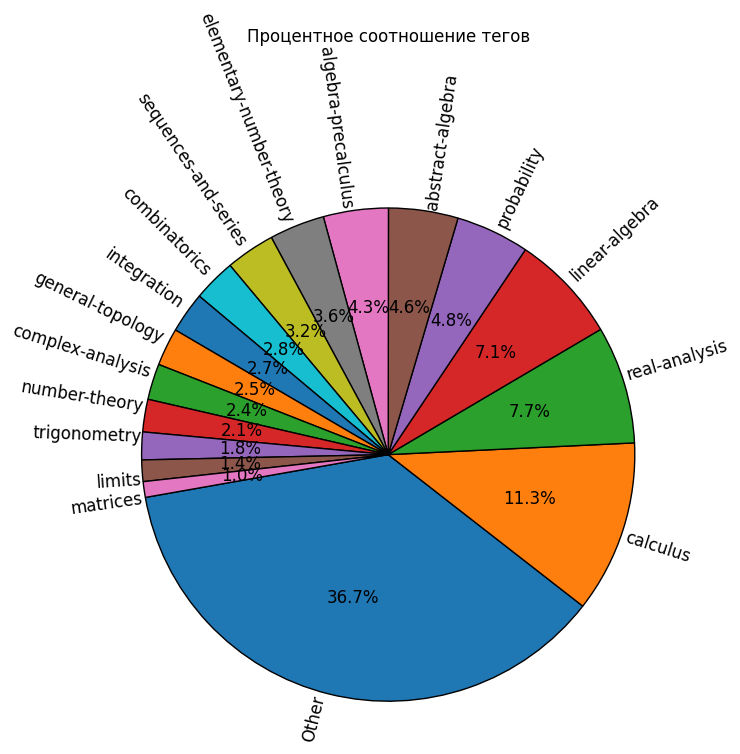

In [23]:
tag_counts = df['tags'].value_counts()
plt.figure(figsize=(7, 7))
plt.pie(tag_counts, labels=tag_counts.index, autopct='%1.1f%%', startangle=190,
        labeldistance=1,  textprops={'fontsize': 12}, rotatelabels=True,  wedgeprops={'edgecolor': 'black'})
plt.title('Процентное соотношение тегов', y=1.25)
plt.axis('equal')
plt.show()

In [24]:
df

,Unnamed: 0,text_id,output_texts,input_texts,tags,augmentation,formulae_only
2776,7643,809475,"Проблемы этого типа, взятые из книг, часто уяз...","Проблемы этого типа, взятые из книг, часто уяз...",complex-analysis,num2word,False
11148,2341,806979,"Чтобы две ладьи могли атаковать друг друга, он...","Чтобы две ладьи могли атаковать друг друга, он...",combinatorics,all_augments,False
4728,3345,903541,Пусть $B_W$ — базис для $W$. Расширьте его до ...,Пусть B_W — базис для W. Расширьте его до бази...,linear-algebra,rand_delet_and_typo,False
11692,315,109760,$$_x000D_\n\left(1-\left(1-\frac1n\right)^{f(n...,_x000D_\n\left 1-\left 1-\frac1n\right)^{f n...,limits,rand_delet_and_typo,True
5678,11423,113713,$$x=5\pm2\sqrt{6}$$,$$x=пять\pmвторой\sqrt{шесть}$$,Other,num2word,True
...,...,...,...,...,...,...,...
5418,5871,135529,$$ \sum_{n\geq 2}\frac{a_n^2}{2n+1}\geq 0 \tag...,$$ \sum_{n\geq два}\frac{a_n^второй}{дваn+перв...,Other,num2word,True
2892,4970,83950,\begin{align}_x000D_\n\lambda^*(E)+\lambda^*(E...,\begin{align _x000D_\n\lambda^*( э прописная ...,real-analysis,all_augments,True
2661,669,140304,$$ = b_i*b_m+s*b*b_i-x*b*b_i+b_m*x*i+s*b*x*i-b...,$$ равняется би _ и * бэ _ эм +s*b* бэ _i-x...,Other,synonyms,True
10798,9301,65347,$$ t\leq m(U_t)\leq t\sum_{n=1}^{\infty}2^{1-n...,t\leq m(U_t)\leq t\sum_{n=1}У{\infty}2^{1-n}=2t,Other,rand_delet_and_typo,True


In [25]:
(df.tags.value_counts()/len(df))*100

tags
Other                       36.693333
calculus                    11.286667
real-analysis                7.720000
linear-algebra               7.133333
probability                  4.820000
abstract-algebra             4.553333
algebra-precalculus          4.253333
elementary-number-theory     3.620000
sequences-and-series         3.226667
combinatorics                2.806667
integration                  2.680000
general-topology             2.473333
complex-analysis             2.353333
number-theory                2.133333
trigonometry                 1.813333
limits                       1.406667
matrices                     1.026667
Name: count, dtype: float64

In [26]:
df.tags.value_counts()

tags
Other                       5504
calculus                    1693
real-analysis               1158
linear-algebra              1070
probability                  723
abstract-algebra             683
algebra-precalculus          638
elementary-number-theory     543
sequences-and-series         484
combinatorics                421
integration                  402
general-topology             371
complex-analysis             353
number-theory                320
trigonometry                 272
limits                       211
matrices                     154
Name: count, dtype: int64

In [27]:
med_len = df['output_texts'].str.len().median()

In [28]:
med_len

172.0

In [29]:
df[['output_texts','input_texts']]=df[['output_texts','input_texts']].astype(str)

In [30]:
# при возникновении проблем с экселем
!pip install openpyxl

In [31]:
from openpyxl.utils.escape import unescape

In [32]:
for str_col in df.select_dtypes(include=['object']).columns:
    df[str_col] = df[str_col].astype(str).apply(unescape)

In [33]:
len(df)

15000

In [34]:
df = df[~(  (df.output_texts.str.len()==1) | (df.input_texts.str.len()==1))]

In [35]:
len(df)

14982

In [37]:
class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=int(med_len)):
        df.reset_index(drop=True, inplace=True)
        self.outputs = df["output_texts"]
        self.inputs = df["input_texts"]
        self.tags = df['tags']
        self.tokenizer = tokenizer
        self.max_len=max_len

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        # для t5-small
        item = {}
        #print(index)
        
        inputs = self.tokenizer(self.inputs[index],return_tensors='pt',
                                padding='max_length',truncation=True,
                                return_attention_mask=True,max_length=self.max_len)
        outputs = self.tokenizer(self.outputs[index],return_tensors='pt',
                                 padding='max_length',truncation=True, 
                                 return_attention_mask=True,max_length=self.max_len)
        
        item['input_ids'] = inputs['input_ids'].squeeze().to(device)
        item['attention_mask'] = inputs['attention_mask'].squeeze().to(device)
        item['labels'] = outputs['input_ids'].squeeze().to(device)
        return item
    def get_item_tag(self,index):
        return self.tags[index]

In [39]:
test_dataset=df

In [40]:
BATCH_SIZE=40
test_dataset = CustomDataset(test_dataset, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=False)

In [41]:
from tqdm.auto import tqdm
from transformers import get_scheduler

In [42]:
%%time

model.eval()
#model.to(device)

test_metrics = []
hyps = []
all_preds=[]
with torch.no_grad():
    for batch in tqdm(test_loader, desc='testing'):
        batch['input_ids']=batch['input_ids'].to(device)
        phrases = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)
        hypotheses = []
        
        for tens_to_be, phrase in zip(batch['input_ids'],phrases):
            max_len = len(phrase)
            try: 
                one_pred = model.generate(
                    tens_to_be.unsqueeze(0),
                    do_sample=True, 
                    num_beams=10,
                    num_return_sequences=1, 
                    repetition_penalty=1.2,
                    max_length=max_len 
                )
                hyps.append(one_pred.tolist()[0])
            except Error as e:
                print(f"There was an error: {e}\nOn phrase:{phrase}")
                hyps.append([0 for i in range(100)])
                pass
                
        hyps = tokenizer.batch_decode(hyps, skip_special_tokens=True)

        all_preds.append(hyps)
        for generated, label in zip(hyps, phrases):
            metric = Levenshtein.normalized_similarity(generated, label)
            test_metrics.append(metric)
        hyps=[]

print(test_metrics)

testing:   0%|          | 0/375 [00:00<?, ?it/s]

[0.9858156028368794, 0.9840637450199203, 0.8922558922558923, 0.9523809523809523, 1.0, 1.0, 0.6553524804177546, 0.7957317073170732, 0.875, 0.5982142857142857, 0.9764705882352941, 0.9047619047619048, 0.9054054054054054, 0.730909090909091, 0.7857142857142857, 0.9781021897810219, 0.9156626506024097, 0.8333333333333334, 0.96875, 0.967741935483871, 0.9351851851851852, 0.9929328621908127, 0.9203539823008849, 0.928, 0.8787878787878788, 0.9659090909090909, 1.0, 0.9916317991631799, 0.9673202614379085, 0.9668508287292817, 0.9150326797385621, 0.9285714285714286, 0.9680851063829787, 0.7492877492877492, 0.9905660377358491, 0.8787878787878788, 0.5296803652968036, 0.9416445623342176, 0.9122807017543859, 0.9565217391304348, 0.8566037735849057, 0.968421052631579, 0.9393939393939394, 1.0, 0.9624060150375939, 0.9565217391304348, 0.9175627240143369, 0.9714285714285714, 1.0, 0.9688888888888889, 0.9767441860465116, 0.9285714285714286, 1.0, 0.9456869009584664, 1.0, 1.0, 1.0, 0.9166666666666666, 0.905405405405

In [43]:
test_average = sum(test_metrics)/len(test_metrics)
print(f"the average normalized levenshtein similarity is: {test_average}")

the average normalized levenshtein similarity is: 0.9161015384469102


In [46]:
orig_df = df

In [47]:
len(test_metrics)

14982

In [48]:
len(all_preds)

375

In [49]:
preds = [j for i in all_preds for j in i]

In [50]:
len(preds)

14982

In [51]:
data = {'prediction':preds, 'metric':test_metrics}
test_data_df = pd.DataFrame(data)

In [52]:
test_data_df

,prediction,metric
0,"Проблемы этого типа, взятые из книг, часто уяз...",0.985816
1,"Чтобы две ладьи могли атаковать друг друга, он...",0.984064
2,Пусть $B_W$ — базис для W. Расширьте его до ба...,0.892256
3,$\left(1-\left(1-\frac1n\right)^{f(n)}\right)^...,0.952381
4,$$x=5\pm2\sqrt{6}$$,1.000000
...,...,...
14977,$$ \sum_{n\geq 2}\frac{a_n^2}{2n+1}\geq 0 \tag...,1.000000
14978,\begin{align} \lambda^*(E + \lambda^*(E^\compl...,0.595142
14979,$$=b_i*b_m+s^b*b_i-x^b*b_i+b_m*x^i+s^b*x^i-b^i$$,0.777778
14980,$t\leq m(U_t)\leq t\sum_{n=1}^{\infty}2^{1-n}=2t$,0.924528


In [53]:
orig_df.reset_index(inplace=True)

In [54]:
fin_df = pd.concat([orig_df, test_data_df], axis=1)

In [55]:
fin_df

,index,Unnamed: 0,text_id,output_texts,input_texts,tags,augmentation,formulae_only,prediction,metric
0,0,7643,809475,"Проблемы этого типа, взятые из книг, часто уяз...","Проблемы этого типа, взятые из книг, часто уяз...",complex-analysis,num2word,False,"Проблемы этого типа, взятые из книг, часто уяз...",0.985816
1,1,2341,806979,"Чтобы две ладьи могли атаковать друг друга, он...","Чтобы две ладьи могли атаковать друг друга, он...",combinatorics,all_augments,False,"Чтобы две ладьи могли атаковать друг друга, он...",0.984064
2,2,3345,903541,Пусть $B_W$ — базис для $W$. Расширьте его до ...,Пусть B_W — базис для W. Расширьте его до бази...,linear-algebra,rand_delet_and_typo,False,Пусть $B_W$ — базис для W. Расширьте его до ба...,0.892256
3,3,315,109760,$$\r\n\left(1-\left(1-\frac1n\right)^{f(n)}\ri...,\r\n\left 1-\left 1-\frac1n\right)^{f n)}\ri...,limits,rand_delet_and_typo,True,$\left(1-\left(1-\frac1n\right)^{f(n)}\right)^...,0.952381
4,4,11423,113713,$$x=5\pm2\sqrt{6}$$,$$x=пять\pmвторой\sqrt{шесть}$$,Other,num2word,True,$$x=5\pm2\sqrt{6}$$,1.000000
...,...,...,...,...,...,...,...,...,...,...
14977,14977,5871,135529,$$ \sum_{n\geq 2}\frac{a_n^2}{2n+1}\geq 0 \tag...,$$ \sum_{n\geq два}\frac{a_n^второй}{дваn+перв...,Other,num2word,True,$$ \sum_{n\geq 2}\frac{a_n^2}{2n+1}\geq 0 \tag...,1.000000
14978,14978,4970,83950,\begin{align}\r\n\lambda^*(E)+\lambda^*(E^\com...,\begin{align \r\n\lambda^*( э прописная плюс...,real-analysis,all_augments,True,\begin{align} \lambda^*(E + \lambda^*(E^\compl...,0.595142
14979,14979,669,140304,$$ = b_i*b_m+s*b*b_i-x*b*b_i+b_m*x*i+s*b*x*i-b...,$$ равняется би _ и * бэ _ эм +s*b* бэ _i-x...,Other,synonyms,True,$$=b_i*b_m+s^b*b_i-x^b*b_i+b_m*x^i+s^b*x^i-b^i$$,0.777778
14980,14980,9301,65347,$$ t\leq m(U_t)\leq t\sum_{n=1}^{\infty}2^{1-n...,t\leq m(U_t)\leq t\sum_{n=1}У{\infty}2^{1-n}=2t,Other,rand_delet_and_typo,True,$t\leq m(U_t)\leq t\sum_{n=1}^{\infty}2^{1-n}=2t$,0.924528


In [57]:
bad_df = fin_df[fin_df['metric']<0.7]

In [58]:
bad_df['tags'].value_counts()

tags
Other                       231
calculus                     55
probability                  43
linear-algebra               42
real-analysis                40
abstract-algebra             29
algebra-precalculus          20
sequences-and-series         18
trigonometry                 18
complex-analysis             16
elementary-number-theory     14
general-topology             14
combinatorics                14
integration                  10
number-theory                 9
limits                        5
matrices                      5
Name: count, dtype: int64

In [59]:
fin_df['tags'].value_counts()

tags
Other                       5501
calculus                    1689
real-analysis               1157
linear-algebra              1069
probability                  723
abstract-algebra             683
algebra-precalculus          637
elementary-number-theory     542
sequences-and-series         483
combinatorics                421
integration                  399
general-topology             371
complex-analysis             352
number-theory                320
trigonometry                 270
limits                       211
matrices                     154
Name: count, dtype: int64

In [60]:
fin_df[fin_df['metric']>0.4]['metric'].mean()

0.9175130397737546

In [61]:
fin_df['metric'].median()

0.9454545454545454

In [62]:
from datetime import datetime

In [63]:

fin_df.to_parquet(f"FULL_INF_{datetime.now().strftime('%d_%m_%Y')}.parquet")

In [64]:

fin_df.to_excel(f"FULL_INF_{datetime.now().strftime('%d_%m_%Y')}.xlsx", engine="xlsxwriter")

In [65]:
# ключевая информация на инференс 1 итерации:
# 1) у модели плохо с внезапными большими переносами строк и ДЛИННЫМИ фразами
# 2) там где скор >0.96 в основном разница чисто косметическая -- в пробелах
# 3) дополнить аугментацию $$ и $, распространить примеры
# 4) хотелось бы числительные

# ВЫВОДЫ -- аугментировать датасет на числительные + удаление ТОЛЬКО $$ 
# и ничего больше
# дообучить и сравнить результаты